# PROJECT
4-connected grid (Manhattan distance)
input: map
output: self.path coordinates
References:
- Exercice 5

(137, 152)
(548, 711)


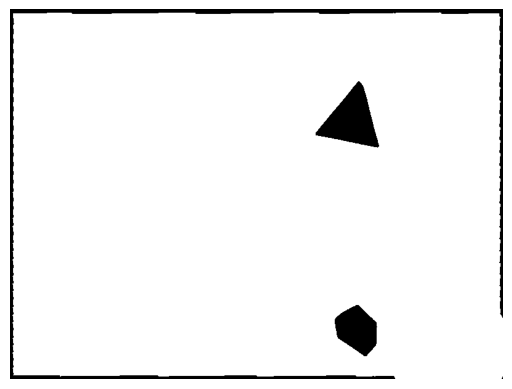

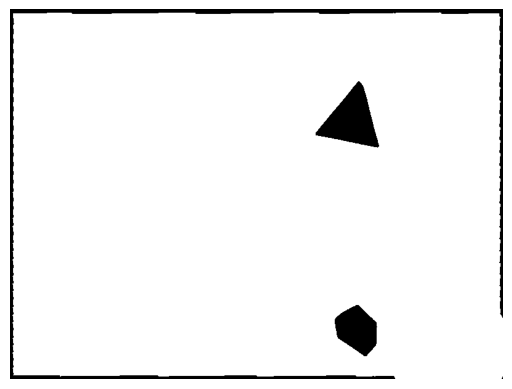

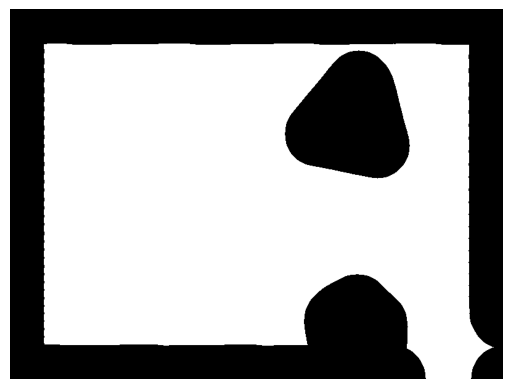

180959 operations to find the optimal path


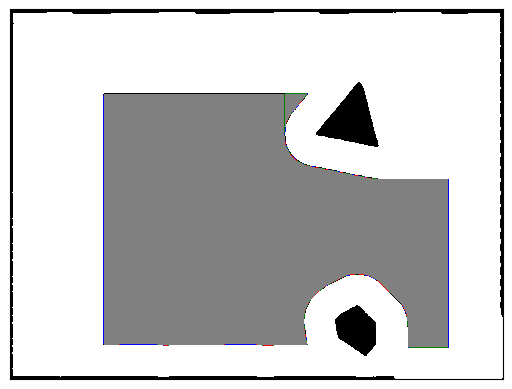

[(152, 137), (153, 137), (154, 137), (155, 137), (156, 137), (157, 137), (158, 137), (159, 137), (160, 137), (161, 137), (162, 137), (163, 137), (164, 137), (165, 137), (166, 137), (167, 137), (168, 137), (169, 137), (170, 137), (171, 137), (172, 137), (173, 137), (174, 137), (175, 137), (176, 137), (177, 137), (178, 137), (179, 137), (180, 137), (181, 137), (182, 137), (183, 137), (184, 137), (185, 137), (186, 137), (187, 137), (188, 137), (189, 137), (190, 137), (191, 137), (192, 137), (193, 137), (194, 137), (195, 137), (196, 137), (197, 137), (198, 137), (199, 137), (200, 137), (201, 137), (202, 137), (203, 137), (204, 137), (205, 137), (206, 137), (207, 137), (208, 137), (209, 137), (210, 137), (211, 137), (212, 137), (213, 137), (214, 137), (215, 137), (216, 137), (217, 137), (218, 137), (219, 137), (220, 137), (221, 137), (222, 137), (223, 137), (224, 137), (225, 137), (226, 137), (227, 137), (228, 137), (229, 137), (230, 137), (231, 137), (232, 137), (233, 137), (234, 137), (23

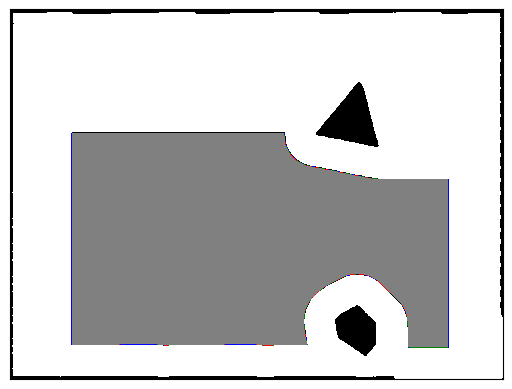

[(100, 200), (101, 200), (102, 200), (103, 200), (104, 200), (105, 200), (106, 200), (107, 200), (108, 200), (109, 200), (110, 200), (111, 200), (112, 200), (113, 200), (114, 200), (115, 200), (116, 200), (117, 200), (118, 200), (119, 200), (120, 200), (121, 200), (122, 200), (123, 200), (124, 200), (125, 200), (126, 200), (127, 200), (128, 200), (129, 200), (130, 200), (131, 200), (132, 200), (133, 200), (134, 200), (135, 200), (136, 200), (137, 200), (138, 200), (139, 200), (140, 200), (141, 200), (142, 200), (143, 200), (144, 200), (145, 200), (146, 200), (147, 200), (148, 200), (149, 200), (150, 200), (151, 200), (152, 200), (153, 200), (154, 200), (155, 200), (156, 200), (157, 200), (158, 200), (159, 200), (160, 200), (161, 200), (162, 200), (163, 200), (164, 200), (165, 200), (166, 200), (167, 200), (168, 200), (169, 200), (170, 200), (171, 200), (172, 200), (173, 200), (174, 200), (175, 200), (176, 200), (177, 200), (178, 200), (179, 200), (180, 200), (181, 200), (182, 200), (18

In [75]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from heapq import heappush, heappop # For priority queue operations in A* algorithm
import cv2 # For image processing tasks
NEW_WIDTH = 800 # grid width
SAFETY = 50 # minimum distance from obstacles


# Handles the global navigation tasks for the robot, including pathfinding and
# avoiding static obstacles using A* algorithm for graph search 
class AStarNavigation:
    def __init__(self, image, safety):
        """
        Initializes the navigation system with a map from vision module and a safety margin.
        
        Parameters:
        - image: The environment map
        - safety: Minimum safe distance (in pixels) from obstacles.
        """
        self.image = image
        self.safety = safety
        self.start = None
        self.goal = None
        self.map_grid = None
        self.path = None
        self.ratio = None
        #self.swapped_path = None

    def visualization_map(self):
        """
        Identifies start and goal,
        visualizes the map, and prepares it for pathfinding.
        """

        # Find the coordinates of the first occurrence of the digit 2, 3
        self.start = tuple(np.argwhere(self.image == 2)[0])
        print(self.start)
        self.goal = tuple(np.argwhere(self.image == 3)[0])
        print(self.goal)

        # Replace all occurrences of the digit 2 and 3 with 0 for the map
        self.image[self.start] = 0
        self.image[self.goal] = 0

        # conversion for display
        self.image = np.where(self.image == 0, 255, self.image)
        self.image = np.where(self.image == 1, 0, self.image)

        plt.imshow(self.image, cmap='gray')
        plt.axis('off')
        plt.savefig('original.png')
        plt.show()
        # print(f"Dimensions of the image: {self.image.shape}")
        
        # Resize the map while maintaining the aspect ratio
        height, width = self.image.shape
        self.ratio = NEW_WIDTH / width
        new_height =  int(self.ratio * height)
        self.image = cv2.resize(self.image, (NEW_WIDTH, new_height), interpolation=cv2.INTER_NEAREST)
        
        # Update the start and goal positions after resizing
        start_y, start_x = self.start
        goal_y, goal_x = self.goal
        self.new_start = (int(start_y * self.ratio), int(start_x * self.ratio))
        self.new_goal = (int(goal_y * self.ratio), int(goal_x * self.ratio))

        
        # Display the self.image
        plt.imshow(self.image, cmap='gray')
        plt.axis('off')
        plt.savefig('pixelized.png')
        plt.show()
    
        # conversion for path planning
        self.image = np.where(self.image == 0, -1., self.image)
        self.image = np.where(self.image == 255, 0., self.image)

    def safety_distance(self):
        """
        Expands obstacles by the safety distance to ensure the robot doesn't get too close to them.
        Returns a processed grid with expanded obstacle areas.
        """
        # Find the coordinates of all black pixels (value -1)
        black_pixels = np.argwhere(self.image == -1)
        self.image_thick = np.full_like(self.image, 255)
        
        # Iterate through each black pixel and draw a gray border around it
        for pixel in black_pixels:
            y, x = pixel
            cv2.circle(self.image_thick, (x, y), self.safety, 0, -1)
        
        plt.imshow(self.image_thick, cmap='gray')
        plt.axis('off')
        plt.savefig('inflated.png')
        plt.show()
    
        # conversion for path planning
        self.image_thick = np.where(self.image_thick == 0, -1., self.image_thick)
        self.image_thick = np.where(self.image_thick == 255, 0., self.image_thick)
        return self.image_thick

    @staticmethod
    def heuristic(a, b):
        """
        Computes the Manhattan distance between two points as a heuristic for A*.
        
        Parameters:
        - a, b: Tuples representing point coordinates (row, col)
        Returns the Manhattan distance
        """
        # Implement the Manhattan distance heuristic
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def algo(self):
        """
        Implements the A* pathfinding algorithm.
        
        Returns:
        - path: List of points forming the path from start to goal
        - explored: Set of pixells explored during pathfinding
        - operation_count: Number of pixels processed
        """
        # Initialize the open set as a priority queue and add the start node
        open_set = []
        heappush(open_set, (self.heuristic(self.new_start, self.new_goal), 0, self.new_start))  # (f_cost, g_cost, position)
    
        # Initialize the came_from dictionary
        came_from = {}
        # Initialize g_costs dictionary with default value of infinity and set g_costs[start] = 0
        g_costs = {self.new_start: 0}
        # Initialize the explored set
        explored = set()
        operation_count = 0
        self.path = []
    
        while open_set:
            # Pop the node with the lowest f_cost from the open set
            current_f_cost, current_g_cost, current_pos = heappop(open_set)
    
            # Add the current node to the explored set
            explored.add(current_pos)
    
            # For directly reconstruct self.path
            if current_pos == self.new_goal:
                break
    
            # Get the neighbors of the current node (up, down, left, right)
            neighbors = [
                (current_pos[0] - 1, current_pos[1]),  # Up
                (current_pos[0] + 1, current_pos[1]),  # Down
                (current_pos[0], current_pos[1] - 1),  # Left
                (current_pos[0], current_pos[1] + 1)#,   # Right
                #(current_pos[0] - 1, current_pos[1] - 1),  # Up-Left todo diag
                #(current_pos[0] - 1, current_pos[1] + 1),  # Up-Right todo diag
                #(current_pos[0] + 1, current_pos[1] - 1),  # Down-Left todo diag
                #(current_pos[0] + 1, current_pos[1] + 1)   # Down-Right todo diag
            ]
    
            for neighbor in neighbors:
                # Check if neighbor is within bounds and not an obstacle
                if (0 <= neighbor[0] < self.map_grid.shape[0]) and (0 <= neighbor[1] < self.map_grid.shape[1]):
                    if self.map_grid[neighbor[0], neighbor[1]] != -1 and neighbor not in explored:
                        # Determine cost for moving (diagonal or cardinal) todo diag
                        #step_cost = np.sqrt(2) if abs(neighbor[0] - current_pos[0]) == 1 and abs(neighbor[1] - current_pos[1]) == 1 else 1
                        # Calculate tentative_g_cost todo diag
                        #tentative_g_cost = current_g_cost + step_cost + self.map_grid[neighbor[0], neighbor[1]]
    
                        # Calculate tentative_g_cost
                        tentative_g_cost = current_g_cost + 1 + self.map_grid[neighbor[0], neighbor[1]] #todo remove if diag
    
                        # If this self.path to neighbor is better than any previous one
                        if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                            # Update came_from, g_costs, and f_cost
                            came_from[neighbor] = current_pos
                            g_costs[neighbor] = tentative_g_cost
                            f_cost = tentative_g_cost + self.heuristic(neighbor, self.new_goal)
    
                            # Add neighbor to open set
                            heappush(open_set, (f_cost, tentative_g_cost, neighbor))
                            operation_count += 1
    
        # Reconstruct path
        if current_pos == self.new_goal:
            path = []
            while current_pos in came_from:
                self.path.append(current_pos)
                current_pos = came_from[current_pos]
            self.path.append(self.new_start)
            return self.path[::-1], explored, operation_count
        else:
            # If we reach here, no path was found
            return None, explored, operation_count

    def display_map(self, explored, path):
        """
        Visualizes the map with obstacles, path, start, goal and explored cells
        
        Parameters:
        - explored: Set of explored cells
        """
        cmap = ListedColormap(['white', 'black', 'blue', 'green', 'red', 'grey'])
        map_display = np.zeros_like(self.image, dtype=object)
    
        # Assign colors based on the map grid values
        map_display[self.image == -1] = 'black'  # Obstacles
        map_display[self.image == 0] = 'white'   # Free space

        for position in explored:
            if map_display[tuple(position)] == 'white':
                map_display[tuple(position)] = 'grey'  # Explored cells
    
        # Visualize the path
        for position in self.path:
            if map_display[position[0], position[1]] in ['white', 'grey']:
                map_display[position[0], position[1]] = 'blue'  # path
    
        map_display[self.new_start[0], self.new_start[1]] = 'green'  # Start
        map_display[self.new_goal[0], self.new_goal[1]] = 'red'      # Goal
    
        # Convert color names to numbers for plotting
        color_mapping = {'white': 0, 'black': 1, 'blue': 2, 'green': 3, 'red': 4, 'grey': 5}
        map_numeric_display = np.vectorize(color_mapping.get)(map_display)
        fig, ax = plt.subplots()
        ax.imshow(map_numeric_display, cmap=cmap)
        ax.set_xticks(np.arange(-0.5, self.image.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.image.shape[0], 1), minor=True)
        #ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.savefig('final_map.png')
        plt.show()

    def pixel_to_grid(self, x, y):
        """
        Match a pixel to its corresponding place in the grid
        """
        grid_x = int(self.ratio * x)
        grid_y = int(self.ratio * y)
        return grid_x, grid_y

    def solution(self, path, explored, operation_count):
        """
        If a solution exists, solution is displayed
        """
        # Display the result
        if path:
            swapped_path = [(x, y) for y, x in self.path][::-1] # uniformize coordonate system
            print(f"{operation_count} operations to find the optimal path")
            self.display_map(explored, path)
            return swapped_path 
        else:
            print("No path found.")
            return None
            
    def run(self):
        """
        Executes the full path-finding pipeline
        """
        self.visualization_map()
        self.map_grid = self.safety_distance()
        path, explored, operation_count = self.algo()
        return self.solution(path, explored, operation_count)

    def new_path(self, new_x, new_y):
        """
        Computes a new path from a given starting point
        """
        operation_count = 0
        self.new_start = (new_y, new_x)
        path, explored, operation_count = self.algo()
        return self.solution(path, explored, operation_count)

    def distance(self, point1, point2):
        """
        Computes the Euclidean distance between 2 points
        """
        return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

    def find_corners(self, swapped_path):
        """
        Identifies key changes of direction along a given path based
    
        Parameters:
        - swapped_path: List of tuples representing the path coordinates
    
        Returns:
        - A list of corner points from the path, where significant direction changes occur
        """
        corners = [swapped_path[0]]
        min_distance = 100 # minimum distance to next corner todo tune
        
        # Iterate through the path and find direction changes
        for i in range(1, len(swapped_path) - 1):
            # Get vectors representing direction
            vector1 = (swapped_path[i][0] - swapped_path[i - 1][0], swapped_path[i][1] - swapped_path[i - 1][1])
            vector2 = (swapped_path[i + 1][0] - swapped_path[i][0], swapped_path[i + 1][1] - swapped_path[i][1])
            
            # Check if the direction changes
            if vector1 != vector2:
                if self.distance(swapped_path[i], corners[-1]) >= min_distance:
                    corners.append(swapped_path[i])
        
        if self.distance(swapped_path[-1], corners[-1]) >= min_distance:
            corners.append(swapped_path[-1])
        
        return corners
        
# calls
file_path = "images/merged_grid_map_6_8.txt"
image = np.loadtxt(file_path)
navigator = AStarNavigation(image, SAFETY)
swapped_path = navigator.run()
print(swapped_path)
corners = navigator.find_corners(swapped_path)
print("Corners:", corners)
x, y = navigator.pixel_to_grid(200, 300)
print(x, y)
swapped_path = navigator.new_path(100, 200)
print(swapped_path)
corners = navigator.find_corners(swapped_path)
print("Corners:", corners)